<span style="font-size:110%; text-align:left;"><b><a href="../index.html">2. Plane Waves</a> > <a href="./index.html">1. Fabry Perot Cavity</a></b></span>
<br/><br/>
<span style="font-size:200%; text-align:left;"><b>Linewidth</b></span>
<br/><br/>
<span style="font-size:110%; text-align:left;">Author: Daniel Töyrä </span>

<img src="linewidth.svg" style="width: 800px" align="center"/>

# Table of Contents
 <p><div class="lev1"><a href="#1.-Introduction">1. Introduction</a></div><div class="lev1"><a href="#2.-Cavity-Linewidth">2. Cavity Linewidth</a></div><div class="lev2"><a href="#2.1.-Optical-layout-and-FINESSE-model">2.1. Optical layout and FINESSE model</a></div><div class="lev2"><a href="#2.2.-FINESSE-example">2.2. FINESSE example</a></div><div class="lev1"><a href="#3.-Tasks">3. Tasks</a></div><div class="lev2"><a href="#3.1.-How-does-the-FSR-depend-on-the-macroscopic-cavity-length">3.1. How does the FSR depend on the macroscopic cavity length</a></div><div class="lev1"><a href="#4.-Tasks-with-answers">4. Tasks with answers</a></div><div class="lev2"><a href="#4.1.-Find-the-linewidth">4.1. Find the linewidth</a></div><div class="lev1"><a href="#5.-Summary">5. Summary</a></div>

# 1. Introduction

The *linewidth* of a cavity is commonly defined as the *Full Width at Half Maximum* (FWHM) of the resonance peak, which we use here. But other definitions are also used, for example the *Half Width at Half Maximum* (HWHM) and the *pole frequency* $f_p$, which both are equal to half the FWHM. The linewidth tells us how large the frequency band is that is resonant inside the cavity, thus, how well the cavity filters out other frequencies. The linewidth is related to the Free Spectral range (see previous notebook) through the cavity finesse, which will be handled in the next notebook.

** Recommended notebooks before you start:**

We recommend that you have looked through the notebook **03_Resonance.ipynb** that you find in the folder [01_Fabry_Perot_cavity](../01_Fabry_Perot_cavity/index.html) before you start this one, or that you have basic experience of IPython/Jupyter Notebooks, PyKat, Finesse, and resonance in a Fabry-Perot cavity. The link above only works if you started IPython/Jupyter Notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3). - Living review article (more like a book) on laser interferometry in the frequency domain for detecting gravitational waves, and FINESSE.

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf). - FINESSE-manual

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/) - Useful online syntax reference for FINESSE. Also available in the Finesse manual [2], but this online version is updated more often.

**After this session you will... **

* be able to tell which cavity properties that affect the cavity linewidth
* have computed the linewidth of a cavity
* have seen how to use `scipy.optimize.scalar()` and `scipy.optimize.bisect()` for finding a local maximum/minimum, and zero crossing.

# 2. Cavity Linewidth

First we import the PyKat and other Python packages that we need:

In [2]:
import numpy as np                         # Importing numpy
import matplotlib                          # For plotting
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool. Change dpi value 
# to change figure sizes on your screen.
pykat.init_pykat_plotting(dpi=90)          

                                              ..-
    PyKat 1.0.4           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



## 2.1. Optical layout and FINESSE model

The setup we use is the same as we used in the three previous notebook. It consists of an input laser, and two mirror forming a cavity as we see below. To be able to measure the laser power we also need photo diodes, which in FINESSE are able to measure the power without interfering with the beam.

<img src="fabry-perot.svg" style="width: 500px;"/>

Now we crate our FINESSE model of the optical setup:

In [3]:
basekat=finesse.kat() # initialising Finesse
basekat.verbose = False
basecode = """
l laser 1 0 n0   # Laser (Power = 1 W, wavelength offset = 0)
s s1 1 n0 nc1    # Space (Length = 1 m)

## The cavity ##
m m1 0.7 0.3 0 nc1 nc2  # Mirror  (R = 0.7, T = 0.3, phi = 0)
s sL 4000 nc2 nc3       # Space (Length = 4 km)
m m2 0.8 0.2 0 nc3 nc4  # Mirror  (R = 0.8, T = 0.2, phi = 0)
"""
basekat.parseKatCode(basecode) # Parsing the FINESSE-code

## 2.2. FINESSE example

In the example in the previous notebook on free spectral range, we can clearly see that the peaks become narrower the longer the cavity is, so we know that the linewidth depends on the cavity length. In this example we will show that linewidth also depends on the reflectance of the mirrors. We will do three runs, each with a different set of mirror reflectances. 

First we add detectors and simulation instructions:

In [4]:
kat1 = basekat.deepcopy()
code = '''
## Detectors ##
# Photo diodes measuring DC-power
pd refl nc1        # Reflected 
pd circ nc2        # Circulating
pd tran nc4        # Transmitted

## Simulation instructions ##
xaxis laser f lin -15k 15k 1000   # Sweeping the laser frequency
yaxis abs                        # Returns magnitude of detector outputs
'''
# Parsing the FINESSE code
kat1.parseCommands(code)

Now, we run the simulation three times, but we change the reflectance of the mirrors (also the transmittance since we use lossless mirrors) between each run. We store the outputs in `out1a`, `out1b`, and `out1c`.

In [5]:
# 1st run, original, R1 = 0.7, R2 = 0.8
out1a = kat1.run()

# 2nd run, R1 = 0.9, R2 = 0.8
kat1.m1.R = 0.9
kat1.m1.T = 0.1
out1b = kat1.run()

# 3rd run, R1 = 0.9, R2 = 0.95
kat1.m2.R = 0.95
kat1.m2.T = 0.05
out1c = kat1.run()

Finally, we plot the results:

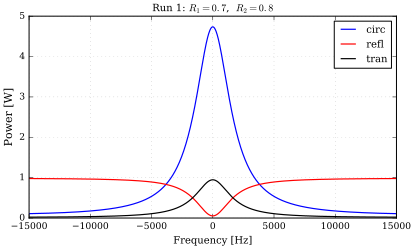

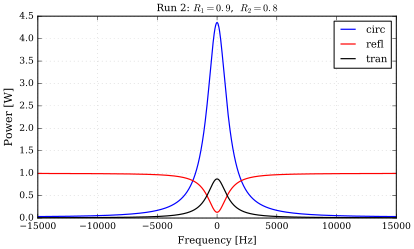

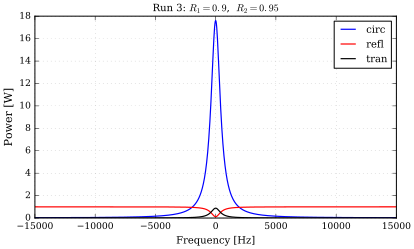

In [6]:
# Run 1
fig1a = out1a.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 1: $R_1 = 0.7$,  $R_2 = 0.8$')
# Run 2
fig1b = out1b.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 2: $R_1 = 0.9$,  $R_2 = 0.8$')
# Run 3
fig1c = out1c.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 3: $R_1 = 0.9$,  $R_2 = 0.95$')

We can clearly see that the linewidth of the peak decreases with increasing mirror reflectance. How the relationship between the linewidth and the reflectance of the mirrors looks like will be investigated below in task 3.1.

# 3. Tasks

## 3.1. How does the FSR depend on the macroscopic cavity length

Investigate how the FSR depends on the macroscopic cavity length by testing a couple of different lengths. Find the FSR of each run either manually by "zooming" in the peaks with the FINESSE command `xaxis`, or by making use of the  `scipy.optimize` library, where I would suggest `scipy.optimize.minimize_scalar()` (see hint below). Try to also work out an analytical expression for the FSR of a cavity, and compare with your simulated result.

**Hint on using ```scipy.optimize.minimize_scalar()``` : **

`scipy.optimize.minimize_scalar()` requires as its first argument a name of a function to be minimised, so first define a function. For example like this (not exactly in this form, you need to do a small change for your task):
```python
def my_function(x):
        kat.laser.f = x
        out = kat.run()
        return out['tran']
```

In the Finesse code you can replace the `xaxis` command with `noxaxis` so that a call to `kat.run()` returns only one value, which is necessary for `minimize_scalar()` to work. 

Then you can call the scipy function to find the minimum of ` my_function()` as:

```python
import scipy.optimize as opt
opt.minimize_scalar(my_function, ...)
```

**Answer:**

# 4. Tasks with answers

## 4.1. Find the linewidth

Compute the linewidth of the example cavity, either manually by "zooming" in the peaks with the FINESSE command `xaxis`, or by making use of the  `scipy.optimize` library, where I would suggest `scipy.optimize.minimize_scalar()` in combination with `scipy.optimize.bisect()` (see hint below). Try to also work out an analytical expression for the FSR of a cavity, and compare with your simulated results.

**Hint on using `scipy.optimize.minimize_scalar()` and `scipy.optimize.bisect()`: **

Both `scipy.optimize.minimize_scalar()` and `scipy.optimize.bisect()` require as their first argument a name of a function, so you first need to define a function. For example like this (not exactly in this form, you need to do a small change for your task):
```python
def my_function(x):
        kat.laser.f = x
        out = kat.run()
        return out['tran']
```

In the Finesse code you can replace the `xaxis` command with `noxaxis` so that a call to `kat.run()` returns only one value, which is necessary for `minimize_scalar()` and `bisect()` to work. 

Then you can call the scipy functions to perform the wanted optimisation  on ` my_function()` as:

```python
import scipy.optimize as opt
opt.minimize_scalar(my_function, ...)
```

**Answer:**

We start by copying `basekat`, adding a photo diode detecting circulating power, and adding simulation instructions. Note that we use the command `noxaxis`, which means that we just runs the current setup, i.e., only one data point. 

In [7]:
kat2 = basekat.deepcopy()  # Copying basekat

# Adding detectors and simulation instructions
code = '''
## Detectors ##
pd circ nc2         # Measuringn circulating power

## Simulation instructions ##
noxaxis             # Changing nothing, just running current setup.
yaxis abs           # Returns absolute value of the detector output
'''

# Parsing the FINESSE code
kat2.parseCommands(code)

Now we write the function `find_fwhm()` that requires a `kat`-object as the only input, and it returns the FWHM of the cavity as long as we have a detector measuring the circulating or transmitted power, and no other detectors. As you see below, the function `find_fwhm()` has two inner functions as well: one that finds maximums, and one that finds zero crossings. `find_fwhm` operates in two steps:

* Finds the maximum by using `minimize_scalar()`, and stores it.
* Uses half the maximum to offset the function that is used to find the zero crossing such that it crossers zero when the resonance peak has dropped half its power.

In [8]:
import scipy.optimize as opt

def find_fwhm(kat):
# Function for finding FSR of a cavity
    
    # Finding the laser component of the kat-object
    laser = kat.getAll(pykat.components.laser)[0]
    
    def find_max(f):
    # Function that is minimised at the frequency f
    # that gives maximum transmitted power. 

        laser.f = f             # Setting new laser frequency
        out_max = kat.run()     # Running
        return -out_max.y[0,0]  # Output

    def find_pole(f, P1):
    # Function that crosses zero when the measured power 
    # equals P1.
        
        laser.f = f
        out_pole = kat.run()
        return out_pole.y[0,0]-P1
    
    
    # Step 1: Finding the peak power
    # -------------------------------
    
    opts = {'xtol': 1.0e-6, 'maxiter': 500}
    # Calling minimize_scalar with Brent's method to 
    # find minimum of find_max().
    sol_1 = opt.minimize_scalar(find_max, 
                                method='brent', 
                                options=opts)
    P_half = -sol_1.fun/2
    f0 = sol_1.x
    
    print('Maximum found: P = {0:.3f} W,  f0 = {1:.2e} Hz'
          .format(2*P_half,f0))

    # Step 2: Finding the Pole frequency
    # -----------------------------------
    
    # Calling bisect() to find where the power is equal to half the
    # the peak power, thus P_half.
    fp = opt.bisect(find_pole, 0, 1.0e4, args=(P_half), xtol=1e-6)
    
    fwhm = 2*(fp-f0)     # Computing FWHM


    print('Pole found: f_p = {0:.2e} Hz'.format(fp))
    print('FWHM = {0:.2e} Hz'.format(fwhm))
    print()
    
    return fwhm

Now we test our function for 3 different mirror reflectance configurations.

In [9]:
fwhm = []   # List for storing simulated fwhm
FWHM = []   # List for storing analytical fwhm

c = 299792458.0      # Speed of light
L = kat2.sL.L.value  # Length of cavity

# 1st run, original, R1 = 0.7, R2 = 0.8
# --------------------------------------
R1 = 0.7
R2 = 0.8
# Simulated
fwhm.append(find_fwhm(kat2))
# Analytical 
FWHM.append( (c/(L*np.pi))*
            np.arcsin( (1-np.sqrt(R1*R2))/(2*(R1*R2)**(1/4) ) ) )

# 2nd run, R1 = 0.9, R2 = 0.8
# ---------------------------------------
R1 = 0.9
kat2.m1.R = R1
kat2.m1.T = 1-R1
# Simulated
fwhm.append(find_fwhm(kat2))
# Analytical 
FWHM.append( (c/(L*np.pi))*
            np.arcsin( (1-np.sqrt(R1*R2))/(2*(R1*R2)**(1/4) ) ) )

# 3rd run, R1 = 0.9, R2 = 0.95
R2 = 0.95
kat2.m2.R = R2
kat2.m2.T = 1-R2
# Simulated
fwhm.append(find_fwhm(kat2))
# Analytical
FWHM.append( (c/(L*np.pi))*
            np.arcsin( (1-np.sqrt(R1*R2))/(2*(R1*R2)**(1/4) ) ) )

Maximum found: P = 4.737 W,  f0 = -8.47e-09 Hz
Pole found: f_p = 1.74e+03 Hz
FWHM = 3.48e+03 Hz

Maximum found: P = 4.358 W,  f0 = -3.08e-08 Hz
Pole found: f_p = 9.82e+02 Hz
FWHM = 1.96e+03 Hz

Maximum found: P = 17.619 W,  f0 = -1.27e-07 Hz
Pole found: f_p = 4.67e+02 Hz
FWHM = 9.35e+02 Hz



Printing the results to screen:

In [25]:
print('Cavity Linewidth in FWHM [Hz]')
print('--------------------------------------------------------------')
print('Run: \t\t1 \t\t2 \t\t3')
print('[R1, R2]: \t[{0}, {1}] \t[{2}, {1}] \t[{2}, {3}]'
      .format(0.7,0.8,0.9,0.95))
print('Computed: \t{0[0]:.4e} Hz\t{0[1]:.4e} Hz\t{0[2]:.4e} Hz'
      .format(fwhm))
print('Analytical: \t{0[0]:.4e} Hz\t{0[1]:.4e} Hz\t{0[2]:.4e} Hz'
      .format(FWHM))
print('--------------------------------------------------------------')

Cavity Linewidth in FWHM [Hz]
--------------------------------------------------------------
Run: 		1 		2 		3
[R1, R2]: 	[0.7, 0.8] 	[0.9, 0.8] 	[0.9, 0.95]
Computed: 	3.4826e+03 Hz	1.9637e+03 Hz	9.3479e+02 Hz
Analytical: 	3.4826e+03 Hz	1.9637e+03 Hz	9.3479e+02 Hz
--------------------------------------------------------------


We see that our computed values agree well with the analytical calculations. The analytical solution is taken from the living review article [1], section 5.2, and looks like this:

\begin{align}
\mathrm{FWHM} = \frac{c}{\pi L}\arcsin \left[ \frac{1-r_1 r_2}{2\sqrt{r_1 r_2}} \right],
\end{align}

where $r_x = \sqrt{R_x}$.

# 5. Summary

In this session we have ...
* seen that the cavity linewidth depends on the cavity length and the reflectance of the mirrors.
* computed the linewidth of a cavity
* seen the analytical expression for the linewidth

In the next session [Finesse](05_Finesse.html) we will go through what is meant by *Finesse* of a cavity.